In [5]:
 !pip install kaggle

In [6]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
!cp kaggle.json ~/.kaggle/

In [8]:
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
#https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection

In [10]:
! kaggle datasets download ahmedhamada0/brain-tumor-detection

 98% 82.0M/84.0M [00:00<00:00, 159MB/s]
100% 84.0M/84.0M [00:00<00:00, 129MB/s]


In [11]:
!unzip brain-tumor-detection.zip

Archive:  brain-tumor-detection.zip
  inflating: Br35H-Mask-RCNN/TEST/annotations_test.json  
  inflating: Br35H-Mask-RCNN/TEST/y701.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y702.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y703.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y704.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y705.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y706.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y707.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y708.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y709.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y710.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y711.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y712.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y713.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y714.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y715.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y716.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y717.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y718.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y719.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y720.jpg  
  infl

In [12]:
import os
import glob
import shutil
import random
import pandas as pd
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
def importing_data(path):
    sample = []
    for filename in glob.glob(path):
        sample.append(filename)
    return sample

In [14]:
path1 = 'no/*.jpg'
path2 = 'yes/*.jpg'
path3 = 'pred/*.jpg'

train_n = importing_data(path1)
train_y = importing_data(path2)
test = importing_data(path3)

#%% CREATION OF DATASETS

df_train_n = pd.DataFrame({'image':train_n, 'label': 'Healthy'})
df_train_y = pd.DataFrame({'image':train_y, 'label': 'Affected'})
df_test = pd.DataFrame({'image':test})
train_data = pd.concat([df_train_n, df_train_y])
train_data.head()

,image,label
0,no/no682.jpg,Healthy
1,no/No15.jpg,Healthy
2,no/no776.jpg,Healthy
3,no/no1072.jpg,Healthy
4,no/no798.jpg,Healthy


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(train_data,
                                  test_size = 0.1,
                                  shuffle = True,
                                  random_state = 42)

In [16]:
import keras
from keras.metrics import AUC, Recall, Precision
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D , MaxPooling2D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import RMSprop

def build_model():

    '''Sequential Model creation'''
    CNN = Sequential()

    CNN.add(Conv2D(64,(5,5), activation = 'relu', padding = 'same',
                   strides=(2,2), input_shape = [224,224,1]))
    CNN.add(MaxPooling2D(2))
    CNN.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    CNN.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    CNN.add(Conv2D(256,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    CNN.add(MaxPooling2D(2))
    #CNN.add(GlobalAveragePooling2D())
    CNN.add(Flatten())
    CNN.add(Dense(64, activation = 'relu'))
    CNN.add(Dropout(0.4))
    CNN.add(Dense(32, activation = 'relu'))
    CNN.add(Dropout(0.4))
    CNN.add(Dense(2, activation = 'softmax'))

    return CNN

keras_model = build_model()
keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      1664      
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       204928    
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)         819456    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 256)         0         
 g2D)                                                   

In [17]:
def Model_fit(train_data, val_data):

    keras_model = None

    keras_model = build_model()

    '''Compiling the model'''

    keras_model.compile(optimizer = RMSprop(learning_rate = 1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics =['acc'])

    es = EarlyStopping(monitor='val_loss', mode='min',
                       patience=2,
                       restore_best_weights=True,
                       verbose=1)


    checkpoint_cb = ModelCheckpoint("Brain_model_best.h5",
                                    save_best_only=True)

    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 3,
                                  min_lr = 1e-5,
                                  mode = 'min',
                                  verbose=1)


    history = keras_model.fit(train_data,
                              validation_data = val_data,
                              epochs= 50,
                              batch_size = 10,
                              callbacks=[es, checkpoint_cb, reduce_lr])



    return history

In [18]:
from keras.preprocessing.image import ImageDataGenerator

k_fold = 3
IMG_SIZE = 224
size = (IMG_SIZE,IMG_SIZE)

def CV_training(train_data, val_data):

    cv_histories = []

    for i in range(0,k_fold):

        datagen = ImageDataGenerator(rescale = 1./255)

        train_set = datagen.flow_from_dataframe(train_data,
                                                x_col = 'image',
                                                y_col = 'label',
                                                target_size = size,
                                                color_mode = 'grayscale',
                                                class_mode = 'sparse',
                                                batch_size = 10,
                                                shuffle = True,
                                                interpolation = 'bilinear')

        val_set = datagen.flow_from_dataframe(val_data,
                                              x_col = 'image',
                                              y_col = 'label',
                                              target_size = size,
                                              color_mode = 'grayscale',
                                              class_mode = 'sparse',
                                              batch_size = 10,
                                              shuffle = True,
                                              interpolation = 'bilinear')
        print("Training on Fold: ",i+1)

        cv_histories.append(Model_fit(train_set, val_set))

    return cv_histories

cv_results = CV_training(X_train,X_val)

Found 2700 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.
Training on Fold:  1
Epoch 1/50
270/270 [==============================] - 15s 34ms/step - loss: 0.6544 - acc: 0.5922 - val_loss: 0.6139 - val_acc: 0.6800 - lr: 1.0000e-04
Epoch 2/50
  3/270 [..............................] - ETA: 7s - loss: 0.6343 - acc: 0.7000 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


270/270 [==============================] - 9s 32ms/step - loss: 0.5749 - acc: 0.7267 - val_loss: 0.5104 - val_acc: 0.7500 - lr: 1.0000e-04
Epoch 3/50
270/270 [==============================] - 8s 28ms/step - loss: 0.4750 - acc: 0.7859 - val_loss: 0.4239 - val_acc: 0.7933 - lr: 1.0000e-04
Epoch 4/50
270/270 [==============================] - 9s 35ms/step - loss: 0.3508 - acc: 0.8600 - val_loss: 0.3025 - val_acc: 0.8633 - lr: 1.0000e-04
Epoch 5/50
270/270 [==============================] - 8s 31ms/step - loss: 0.2439 - acc: 0.9115 - val_loss: 0.2117 - val_acc: 0.9267 - lr: 1.0000e-04
Epoch 6/50
270/270 [==============================] - 8s 29ms/step - loss: 0.1611 - acc: 0.9522 - val_loss: 0.2224 - val_acc: 0.9200 - lr: 1.0000e-04
Epoch 7/50
270/270 [==============================] - 9s 33ms/step - loss: 0.1099 - acc: 0.9656 - val_loss: 0.1373 - val_acc: 0.9467 - lr: 1.0000e-04
Epoch 8/50
270/270 [==============================] - 9s 33ms/step - loss: 0.0804 - acc: 0.9767 - val_loss: 0.1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
270/270 [==============================] - 9s 33ms/step - loss: 0.5690 - acc: 0.7315 - val_loss: 0.5466 - val_acc: 0.7033 - lr: 1.0000e-04
Epoch 3/50
270/270 [==============================] - 9s 35ms/step - loss: 0.5087 - acc: 0.7707 - val_loss: 0.4788 - val_acc: 0.7500 - lr: 1.0000e-04
Epoch 4/50
270/270 [==============================] - 9s 33ms/step - loss: 0.4227 - acc: 0.8267 - val_loss: 0.4004 - val_acc: 0.8033 - lr: 1.0000e-04
Epoch 5/50
270/270 [==============================] - 9s 32ms/step - loss: 0.3317 - acc: 0.8693 - val_loss: 0.2813 - val_acc: 0.8933 - lr: 1.0000e-04
Epoch 6/50
270/270 [==============================] - 8s 28ms/step - loss: 0.2385 - acc: 0.9204 - val_loss: 0.1919 - val_acc: 0.9267 - lr: 1.0000e-04
Epoch 7/50
270/270 [==============================] - 9s 32ms/step - loss: 0.1638 - acc: 0.9459 - val_loss: 0.1282 - val_acc: 0.9567 - lr: 1.0000e-04
Epoch 8/50
270/270 [==============================] - 9s 32ms/step - loss: 0.1112 - acc: 0.9630 - va

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


270/270 [==============================] - 9s 32ms/step - loss: 0.5358 - acc: 0.7470 - val_loss: 0.5218 - val_acc: 0.7300 - lr: 1.0000e-04
Epoch 3/50
270/270 [==============================] - 7s 28ms/step - loss: 0.4563 - acc: 0.8000 - val_loss: 0.4185 - val_acc: 0.7900 - lr: 1.0000e-04
Epoch 4/50
270/270 [==============================] - 8s 29ms/step - loss: 0.3594 - acc: 0.8485 - val_loss: 0.3026 - val_acc: 0.8600 - lr: 1.0000e-04
Epoch 5/50
270/270 [==============================] - 9s 33ms/step - loss: 0.2626 - acc: 0.8889 - val_loss: 0.2061 - val_acc: 0.9100 - lr: 1.0000e-04
Epoch 6/50
270/270 [==============================] - 7s 27ms/step - loss: 0.1868 - acc: 0.9348 - val_loss: 0.1261 - val_acc: 0.9567 - lr: 1.0000e-04
Epoch 7/50
270/270 [==============================] - 9s 33ms/step - loss: 0.1163 - acc: 0.9689 - val_loss: 0.2625 - val_acc: 0.9067 - lr: 1.0000e-04
Epoch 8/50
270/270 [==============================] - 9s 33ms/step - loss: 0.0881 - acc: 0.9752 - val_loss: 0.2

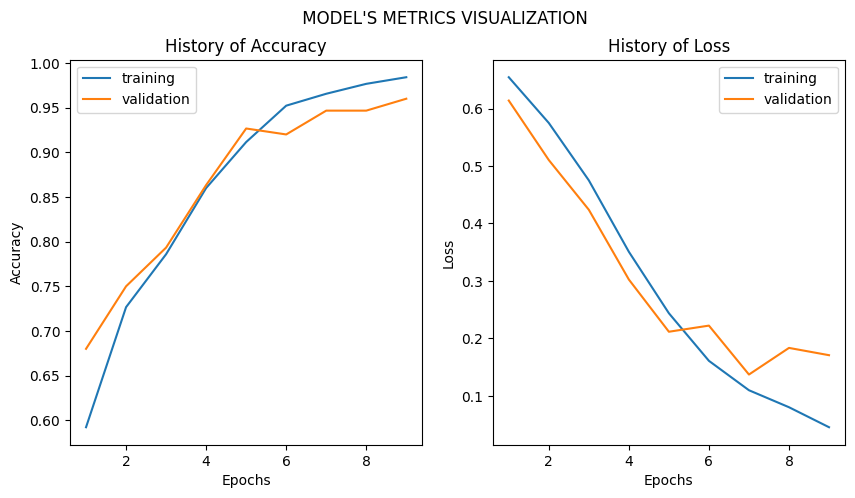

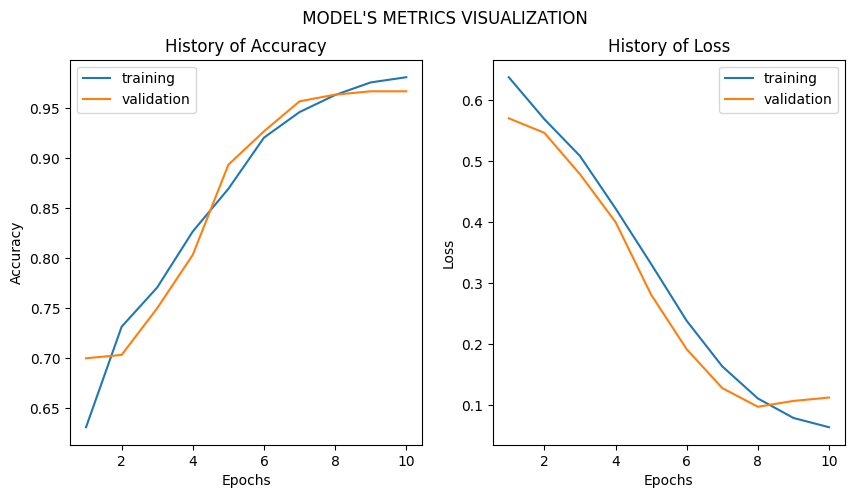

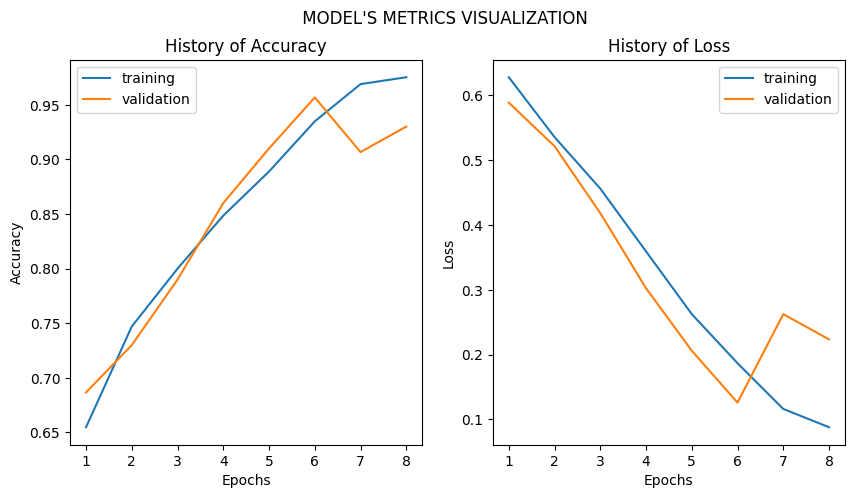

In [19]:
def Acc_Loss_Plot(results):

    for fold in results:

        acc = fold.history['acc']
        val_acc = fold.history['val_acc']
        loss = fold.history['loss']
        val_loss = fold.history['val_loss']

        fig, (ax1, ax2) = plt.subplots(1,2, figsize= (10,5))
        fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

        ax1.plot(range(1, len(acc) + 1), acc)
        ax1.plot(range(1, len(val_acc) + 1), val_acc)
        ax1.set_title('History of Accuracy')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Accuracy')
        ax1.legend(['training', 'validation'])


        ax2.plot(range(1, len(loss) + 1), loss)
        ax2.plot(range(1, len(val_loss) + 1), val_loss)
        ax2.set_title('History of Loss')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Loss')
        ax2.legend(['training', 'validation'])
        plt.show()

Acc_Loss_Plot(cv_results)

In [20]:
import keras

keras_model = keras.models.load_model('Brain_model_best.h5')
keras_model.compile(optimizer = RMSprop(learning_rate = 1e-4),
                    loss='sparse_categorical_crossentropy', metrics =[ 'acc'])

# Predictions on the test set

datagen = ImageDataGenerator(rescale = 1./255)

test_set = datagen.flow_from_dataframe(df_test,
                                       x_col = 'image',
                                       y_col = None,
                                       target_size = size,
                                       color_mode = 'grayscale',
                                       class_mode = None,
                                       batch_size = 10,
                                       shuffle = False,
                                       interpolation = 'bilinear')

predictions = keras_model.predict(test_set)
predictions = predictions.argmax(axis=-1)
print("Where 0 = 'Affected'")
print("Where 1 = 'Healthy'")
print(predictions)

Found 60 validated image filenames.
6/6 [==============================] - 0s 22ms/step
Where 0 = 'Affected'
Where 1 = 'Healthy'
[0 1 1 0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0]


In [21]:
pred = []
[pred.append('Healthy') if i == 1 else pred.append('Affected') for i in predictions]
print(pred)

['Affected', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Affected', 'Affected', 'Affected', 'Affected', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Affected', 'Affected', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Affected']


In [22]:
#%% OBTAINING PREDICTIONS OF THE FIRST BATCH

images10 = [test_set[0][0],test_set[0][1],test_set[0][2],test_set[0][3],test_set[0][4],
            test_set[0][5],test_set[0][6],test_set[0][7],test_set[0][8],test_set[0][9]]

prediction10 = pred[0:9]
final_pred = zip(images10,prediction10)

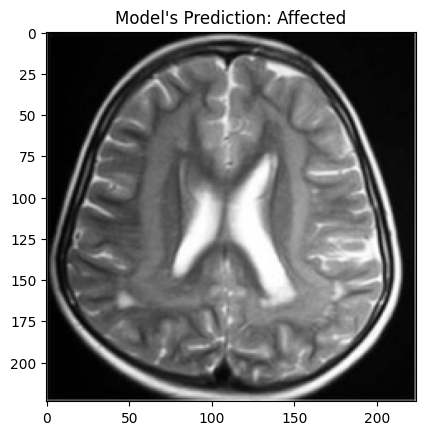

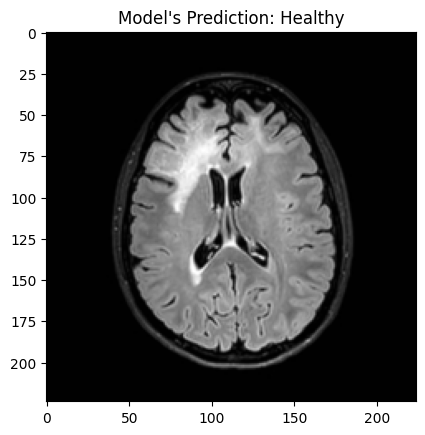

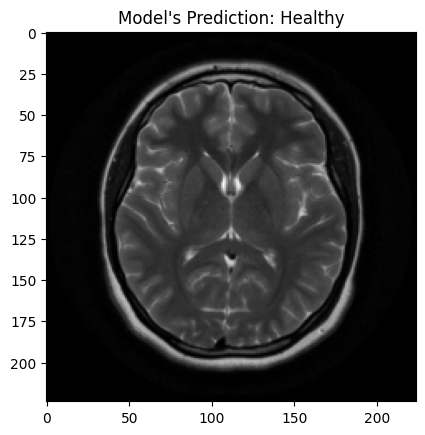

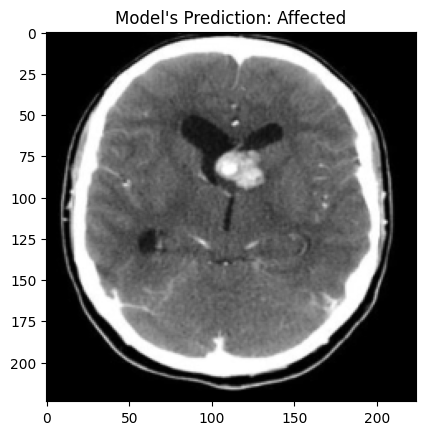

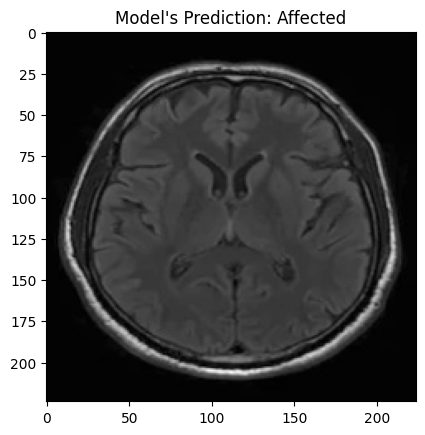

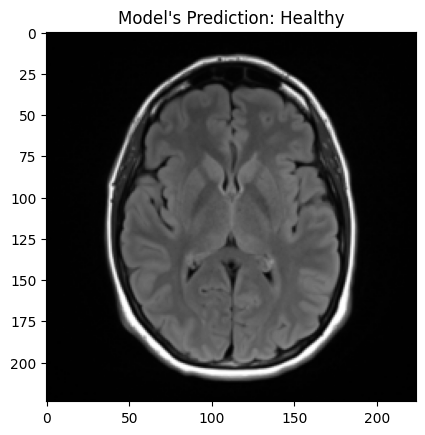

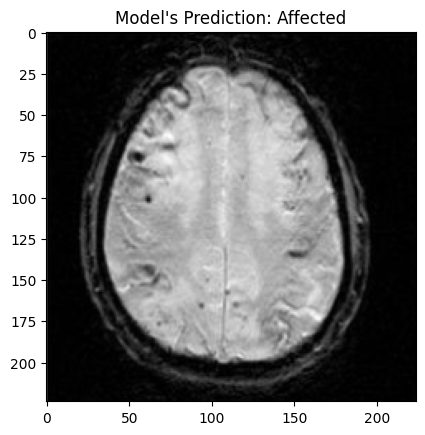

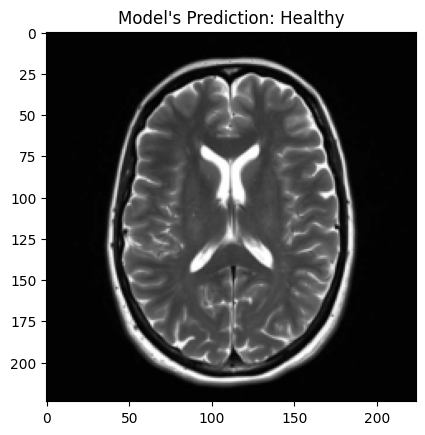

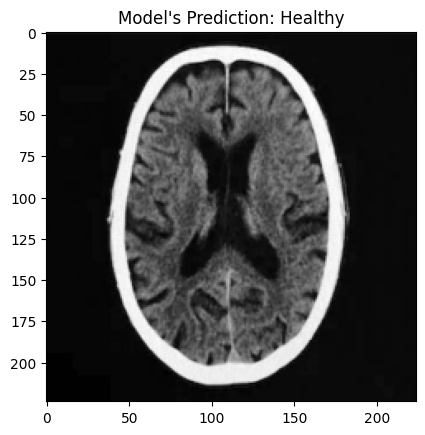

In [23]:
def pre_visualization(data, predictions):

    for image,pred in final_pred:
        plt.imshow(image.reshape(224,224), cmap = 'gray')
        plt.title("Model's Prediction: " + str(pred))
        plt.show()

pre_visualization(images10,prediction10)